# Data

### Data Import

In [2]:
# Loading primary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim_models

In [4]:
df = pd.read_csv('data - data.csv', index_col = "id")

### Data Assessment

In [5]:
df.columns

Index(['created_at', 'date', 'time', 'username', 'name', 'tweet', 'language',
       'hashtags'],
      dtype='object')

In [6]:
df.head()

,created_at,date,time,username,name,tweet,language,hashtags
id,,,,,,,,
3.952669e+16,2011-02-21 03:27:52+00:00,2011-02-21,3:27:52,hbfhealth,HBF,"@AJA_Perth_84 Hi Amanda, can we help? Please e...",en,[]
3.953190e+16,2011-02-21 03:48:35+00:00,2011-02-21,3:48:35,hbfhealth,HBF,The HBF Freeway Bike Hike for Asthma is on Sun...,en,[]
3.953896e+16,2011-02-21 04:16:38+00:00,2011-02-21,4:16:38,hbfhealth,HBF,Did you happen to see our new ad for HBF Essen...,en,[]
3.954256e+16,2011-02-21 04:30:54+00:00,2011-02-21,4:30:54,hbfhealth,HBF,@ashulz @nic_clement Thanks guys! It's great t...,en,[]
3.954793e+16,2011-02-21 04:52:16+00:00,2011-02-21,4:52:16,hbfhealth,HBF,"@DamoMK Hey Damo, unfortunately we can't do th...",en,[]


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76755 entries, 3.95266934252503e+16 to 1.5129940246045123e+18
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  76755 non-null  object
 1   date        76755 non-null  object
 2   time        76755 non-null  object
 3   username    76755 non-null  object
 4   name        76751 non-null  object
 5   tweet       76754 non-null  object
 6   language    76749 non-null  object
 7   hashtags    76749 non-null  object
dtypes: object(8)
memory usage: 5.3+ MB


In [8]:
df.isnull().sum()

,0
created_at,0
date,0
time,0
username,0
name,4
tweet,1
language,6
hashtags,6


In [9]:
df.dropna(inplace=True) # drop the rows with null values

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76746 entries, 3.95266934252503e+16 to 1.5129938001926758e+18
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  76746 non-null  object
 1   date        76746 non-null  object
 2   time        76746 non-null  object
 3   username    76746 non-null  object
 4   name        76746 non-null  object
 5   tweet       76746 non-null  object
 6   language    76746 non-null  object
 7   hashtags    76746 non-null  object
dtypes: object(8)
memory usage: 5.3+ MB


In [11]:
df = df[['date', 'time', 'tweet', 'language']] # drop unncessary columns

In [12]:
df.head()

,date,time,tweet,language
id,,,,
3.952669e+16,2011-02-21,3:27:52,"@AJA_Perth_84 Hi Amanda, can we help? Please e...",en
3.953190e+16,2011-02-21,3:48:35,The HBF Freeway Bike Hike for Asthma is on Sun...,en
3.953896e+16,2011-02-21,4:16:38,Did you happen to see our new ad for HBF Essen...,en
3.954256e+16,2011-02-21,4:30:54,@ashulz @nic_clement Thanks guys! It's great t...,en
3.954793e+16,2011-02-21,4:52:16,"@DamoMK Hey Damo, unfortunately we can't do th...",en


# Pre-Processing

### Lowercase Transformation

In [13]:
df = df[df['language'] == 'en'] # select english language only

In [14]:
df['tweet'] = df['tweet'].str.lower() # transform tweets into lowercase

In [15]:
df.tail()

,date,time,tweet,language
id,,,,
1.512993e+18,2022-04-10,3:16:53,@timodc birth rate has been below replacement ...,en
1.512993e+18,2022-04-10,3:17:02,@skippychurch @dixon_kellie @shaneosc @covie_9...,en
1.512993e+18,2022-04-10,3:18:32,@greghuntmp @insidersabc all means nothing now...,en
1.512994e+18,2022-04-10,3:19:01,whilst australian's 🇦🇺 were totally focused on...,en
1.512994e+18,2022-04-10,3:20:06,@greghuntmp @insidersabc mediscare shows how w...,en


### Remove multi-space and characters followed by '@' Sign

In [16]:
def remove_twitter_ids(tweet):
  mention_removed_tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(tweet)) # remove any sequence of characters followed by '@' sign
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_removed_tweet)) # remove multiple spaces
  return spaces_removed

df['tweet'] = df['tweet'].apply(remove_twitter_ids)

### Remove URL

In [17]:
import re

url_pattern = re.compile(r'https?://\S+')
df['tweet'] = df['tweet'].apply(lambda x: url_pattern.sub('', x))

df.tail()

,date,time,tweet,language
id,,,,
1.512993e+18,2022-04-10,3:16:53,birth rate has been below replacement rate fo...,en
1.512993e+18,2022-04-10,3:17:02,kellie 93 well i wish this were true but the ...,en
1.512993e+18,2022-04-10,3:18:32,all means nothing now that medicare has been ...,en
1.512994e+18,2022-04-10,3:19:01,whilst australians were totally focused on get...,en
1.512994e+18,2022-04-10,3:20:06,mediscare shows how woke labour changes the n...,en


### Remove punctuations

In [18]:
df['tweet'] = df['tweet'].str.replace('[^\w\s]','')

<>:1: DeprecationWarning: invalid escape sequence '\w'
<>:1: DeprecationWarning: invalid escape sequence '\w'
/tmp/ipython-input-915134959.py:1: DeprecationWarning: invalid escape sequence '\w'
  df['tweet'] = df['tweet'].str.replace('[^\w\s]','')


### Remove Duplicates

In [19]:
duplicate_count = len(df['tweet'])-len(df['tweet'].drop_duplicates()) # check duplicate tweet counts
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', df.shape[0])

duplicate count: 12577
total records before remove duplicates: 74234


In [20]:
df = df.drop_duplicates(subset='tweet', keep="first") # drop duplicates (keep the last tweet of each of the duplicates)
print('updated record count:', df.shape[0])

updated record count: 61657


In [21]:
df.tail()

,date,time,tweet,language
id,,,,
1.512993e+18,2022-04-10,3:16:53,birth rate has been below replacement rate fo...,en
1.512993e+18,2022-04-10,3:17:02,kellie 93 well i wish this were true but the ...,en
1.512993e+18,2022-04-10,3:18:32,all means nothing now that medicare has been ...,en
1.512994e+18,2022-04-10,3:19:01,whilst australians were totally focused on get...,en
1.512994e+18,2022-04-10,3:20:06,mediscare shows how woke labour changes the n...,en


### Remove Digits

In [22]:
def remove_digits(tweet): # remove digits
  return " ".join(w for w in tweet.split() if not w.isdigit())

df['tweet'] = df['tweet'].apply(remove_digits)

In [23]:
df.tail()

,date,time,tweet,language
id,,,,
1.512993e+18,2022-04-10,3:16:53,birth rate has been below replacement rate for...,en
1.512993e+18,2022-04-10,3:17:02,kellie well i wish this were true but the mini...,en
1.512993e+18,2022-04-10,3:18:32,all means nothing now that medicare has been c...,en
1.512994e+18,2022-04-10,3:19:01,whilst australians were totally focused on get...,en
1.512994e+18,2022-04-10,3:20:06,mediscare shows how woke labour changes the na...,en


### Stemming

Stemming is the removal of prefix, suffix etc, to derive the base form of a word.

In [24]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemming_function(sent):
  word_list = sent.split()
  stemmed_word_list = [stemmer.stem(word) for word in word_list]
  stemmed_tweet = " ".join(stemmed_word_list)
  return stemmed_tweet

df['tweet_stemmed'] = df['tweet'].apply(stemming_function)

df.head(10)

,date,time,tweet,language,tweet_stemmed
id,,,,,
3.952669e+16,2011-02-21,3:27:52,perth84 hi amanda can we help please email soc...,en,perth84 hi amanda can we help pleas email soci...
3.953190e+16,2011-02-21,3:48:35,the hbf freeway bike hike for asthma is on sun...,en,the hbf freeway bike hike for asthma is on sun...
3.953896e+16,2011-02-21,4:16:38,did you happen to see our new ad for hbf essen...,en,did you happen to see our new ad for hbf essen...
3.954256e+16,2011-02-21,4:30:54,clement thanks guys its great to be here nic,en,clement thank guy it great to be here nic
3.954793e+16,2011-02-21,4:52:16,hey damo unfortunately we cant do that online ...,en,hey damo unfortun we cant do that onlin yet bu...
3.954810e+16,2011-02-21,4:52:56,clement cheers rob,en,clement cheer rob
3.959100e+16,2011-02-21,7:43:24,need some tips on eating well to improve your ...,en,need some tip on eat well to improv your healt...
3.962824e+16,2011-02-21,10:11:22,hopes everyone is safe and out of the perth cbd,en,hope everyon is safe and out of the perth cbd
3.981990e+16,2011-02-21,22:52:59,keep up to date with travel advice from the oz...,en,keep up to date with travel advic from the oz ...


### Lemmatization

Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language.

In [25]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
lemmtizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [26]:
def lemmatize_function(sent):
  word_list = sent.split()
  lemma_word_list = [lemmtizer.lemmatize(word) for word in word_list]
  lemma_tweet = " ".join(lemma_word_list)
  return lemma_tweet

df['tweet_lemmatized'] = df['tweet'].apply(lemmatize_function)

df.head(10)

,date,time,tweet,language,tweet_stemmed,tweet_lemmatized
id,,,,,,
3.952669e+16,2011-02-21,3:27:52,perth84 hi amanda can we help please email soc...,en,perth84 hi amanda can we help pleas email soci...,perth84 hi amanda can we help please email soc...
3.953190e+16,2011-02-21,3:48:35,the hbf freeway bike hike for asthma is on sun...,en,the hbf freeway bike hike for asthma is on sun...,the hbf freeway bike hike for asthma is on sun...
3.953896e+16,2011-02-21,4:16:38,did you happen to see our new ad for hbf essen...,en,did you happen to see our new ad for hbf essen...,did you happen to see our new ad for hbf essen...
3.954256e+16,2011-02-21,4:30:54,clement thanks guys its great to be here nic,en,clement thank guy it great to be here nic,clement thanks guy it great to be here nic
3.954793e+16,2011-02-21,4:52:16,hey damo unfortunately we cant do that online ...,en,hey damo unfortun we cant do that onlin yet bu...,hey damo unfortunately we cant do that online ...
3.954810e+16,2011-02-21,4:52:56,clement cheers rob,en,clement cheer rob,clement cheer rob
3.959100e+16,2011-02-21,7:43:24,need some tips on eating well to improve your ...,en,need some tip on eat well to improv your healt...,need some tip on eating well to improve your h...
3.962824e+16,2011-02-21,10:11:22,hopes everyone is safe and out of the perth cbd,en,hope everyon is safe and out of the perth cbd,hope everyone is safe and out of the perth cbd
3.981990e+16,2011-02-21,22:52:59,keep up to date with travel advice from the oz...,en,keep up to date with travel advic from the oz ...,keep up to date with travel advice from the oz...


In [27]:
df[['tweet', 'tweet_stemmed', 'tweet_lemmatized']].head(10)

,tweet,tweet_stemmed,tweet_lemmatized
id,,,
3.952669e+16,perth84 hi amanda can we help please email soc...,perth84 hi amanda can we help pleas email soci...,perth84 hi amanda can we help please email soc...
3.953190e+16,the hbf freeway bike hike for asthma is on sun...,the hbf freeway bike hike for asthma is on sun...,the hbf freeway bike hike for asthma is on sun...
3.953896e+16,did you happen to see our new ad for hbf essen...,did you happen to see our new ad for hbf essen...,did you happen to see our new ad for hbf essen...
3.954256e+16,clement thanks guys its great to be here nic,clement thank guy it great to be here nic,clement thanks guy it great to be here nic
3.954793e+16,hey damo unfortunately we cant do that online ...,hey damo unfortun we cant do that onlin yet bu...,hey damo unfortunately we cant do that online ...
3.954810e+16,clement cheers rob,clement cheer rob,clement cheer rob
3.959100e+16,need some tips on eating well to improve your ...,need some tip on eat well to improv your healt...,need some tip on eating well to improve your h...
3.962824e+16,hopes everyone is safe and out of the perth cbd,hope everyon is safe and out of the perth cbd,hope everyone is safe and out of the perth cbd
3.981990e+16,keep up to date with travel advice from the oz...,keep up to date with travel advic from the oz ...,keep up to date with travel advice from the oz...


Lemmatization algorithm seems to be working better in this case when compared to the stemming.

# Stop-word and Common word Removal

### Stop-word Removal

Stopwords are deemed irrelevant for NLP purposes because they occur frequently in the language. Therefore, we will omit the stopwords as a pre-processing step.

In [28]:
# Load NLTK library
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
# get the list of all stopwords from the library
stop = stopwords.words('english')
print(stop)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [30]:
stop.remove('not')

In [31]:
df['tweet_lemmatized'] = df['tweet_lemmatized'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df.head()

,date,time,tweet,language,tweet_stemmed,tweet_lemmatized
id,,,,,,
3.952669e+16,2011-02-21,3:27:52,perth84 hi amanda can we help please email soc...,en,perth84 hi amanda can we help pleas email soci...,perth84 hi amanda help please email socialcoma...
3.953190e+16,2011-02-21,3:48:35,the hbf freeway bike hike for asthma is on sun...,en,the hbf freeway bike hike for asthma is on sun...,hbf freeway bike hike asthma sun 20th march ra...
3.953896e+16,2011-02-21,4:16:38,did you happen to see our new ad for hbf essen...,en,did you happen to see our new ad for hbf essen...,happen see new ad hbf essential yesterday not ...
3.954256e+16,2011-02-21,4:30:54,clement thanks guys its great to be here nic,en,clement thank guy it great to be here nic,clement thanks guy great nic
3.954793e+16,2011-02-21,4:52:16,hey damo unfortunately we cant do that online ...,en,hey damo unfortun we cant do that onlin yet bu...,hey damo unfortunately cant online yet em soci...


In [32]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [33]:
df['tweet_lemmatized'] = df['tweet_lemmatized'].apply(lambda x: " ".join(x for x in x.split() if x not in emojis))
df.head(5)

,date,time,tweet,language,tweet_stemmed,tweet_lemmatized
id,,,,,,
3.952669e+16,2011-02-21,3:27:52,perth84 hi amanda can we help please email soc...,en,perth84 hi amanda can we help pleas email soci...,perth84 hi amanda help please email socialcoma...
3.953190e+16,2011-02-21,3:48:35,the hbf freeway bike hike for asthma is on sun...,en,the hbf freeway bike hike for asthma is on sun...,hbf freeway bike hike asthma sun 20th march ra...
3.953896e+16,2011-02-21,4:16:38,did you happen to see our new ad for hbf essen...,en,did you happen to see our new ad for hbf essen...,happen see new ad hbf essential yesterday not ...
3.954256e+16,2011-02-21,4:30:54,clement thanks guys its great to be here nic,en,clement thank guy it great to be here nic,clement thanks guy great nic
3.954793e+16,2011-02-21,4:52:16,hey damo unfortunately we cant do that online ...,en,hey damo unfortun we cant do that onlin yet bu...,hey damo unfortunately cant online yet em soci...


### Common words and Rare words

Aside from stopwords, some words appear commonly or rarely in an entire body of text. Based on the analytics requirement, we have decided to remove some of the common words that would not affect the analysis.

In [34]:
word_frequency = pd.Series(' '.join(df['tweet_lemmatized']).split()).value_counts()

In [35]:
word_frequency[:10] # most common

,count
medicare,29334
medibank,9893
rebate,9792
health,9008
not,8131
amp,6898
get,5698
wa,5694
u,5001
care,4730


In [36]:
word_frequency[-10:] # least common

,count
cameryn,1
employmnet,1
hilda,1
peopleoverpharma,1
peopleoverprofits,1
disintegrating,1
mathew,1
lambasts,1
seatdestruction,1
themselvescant,1


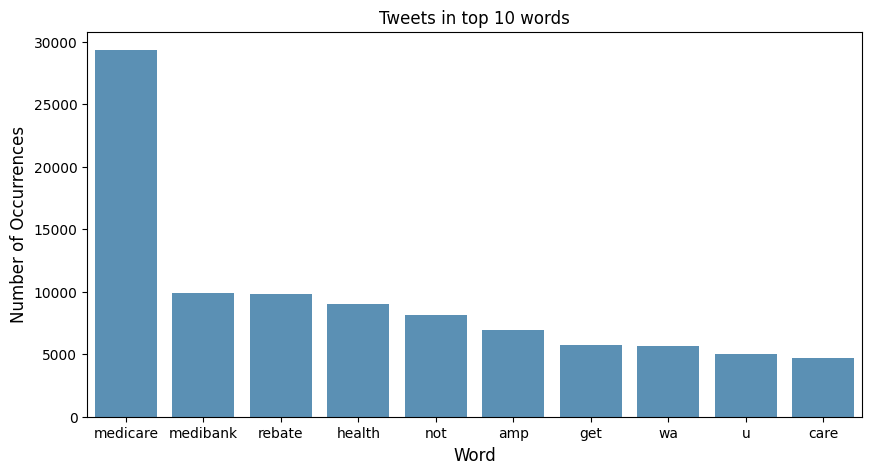

In [37]:
word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(x=word_count.index, y=word_count.values, alpha=0.8)
plt.title('Tweets in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

In [38]:
!pip install wordcloud

In [39]:
from PIL import Image
from wordcloud import WordCloud

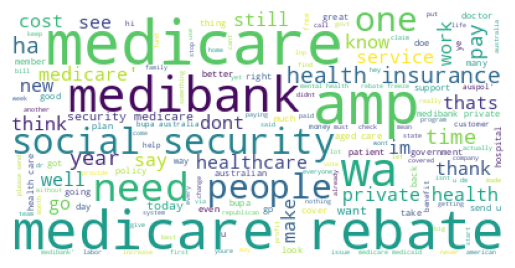

In [40]:
corpus = list(df['tweet_lemmatized'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Remove Common Words

In [41]:
new_words_to_remove = ["medibank", "twitter", "com", "hi", "hey"]

In [42]:
df['tweet_lemmatized'] = df['tweet_lemmatized'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_to_remove))
df.head(10)

,date,time,tweet,language,tweet_stemmed,tweet_lemmatized
id,,,,,,
3.952669e+16,2011-02-21,3:27:52,perth84 hi amanda can we help please email soc...,en,perth84 hi amanda can we help pleas email soci...,perth84 amanda help please email socialcomau w...
3.953190e+16,2011-02-21,3:48:35,the hbf freeway bike hike for asthma is on sun...,en,the hbf freeway bike hike for asthma is on sun...,hbf freeway bike hike asthma sun 20th march ra...
3.953896e+16,2011-02-21,4:16:38,did you happen to see our new ad for hbf essen...,en,did you happen to see our new ad for hbf essen...,happen see new ad hbf essential yesterday not ...
3.954256e+16,2011-02-21,4:30:54,clement thanks guys its great to be here nic,en,clement thank guy it great to be here nic,clement thanks guy great nic
3.954793e+16,2011-02-21,4:52:16,hey damo unfortunately we cant do that online ...,en,hey damo unfortun we cant do that onlin yet bu...,damo unfortunately cant online yet em socialco...
3.954810e+16,2011-02-21,4:52:56,clement cheers rob,en,clement cheer rob,clement cheer rob
3.959100e+16,2011-02-21,7:43:24,need some tips on eating well to improve your ...,en,need some tip on eat well to improv your healt...,need tip eating well improve health checkout d...
3.962824e+16,2011-02-21,10:11:22,hopes everyone is safe and out of the perth cbd,en,hope everyon is safe and out of the perth cbd,hope everyone safe perth cbd
3.981990e+16,2011-02-21,22:52:59,keep up to date with travel advice from the oz...,en,keep up to date with travel advic from the oz ...,keep date travel advice oz govt smartraveller ...


In [43]:
df = df[['date', 'time', 'tweet_lemmatized']]
df.head()

,date,time,tweet_lemmatized
id,,,
3.952669e+16,2011-02-21,3:27:52,perth84 amanda help please email socialcomau w...
3.953190e+16,2011-02-21,3:48:35,hbf freeway bike hike asthma sun 20th march ra...
3.953896e+16,2011-02-21,4:16:38,happen see new ad hbf essential yesterday not ...
3.954256e+16,2011-02-21,4:30:54,clement thanks guy great nic
3.954793e+16,2011-02-21,4:52:16,damo unfortunately cant online yet em socialco...


# Frequency Analysis

In [44]:
word_frequency = pd.Series(' '.join(df['tweet_lemmatized']).split()).value_counts()

In [45]:
word_frequency[:10]

,count
medicare,29334
rebate,9792
health,9008
not,8131
amp,6898
get,5698
wa,5694
u,5001
care,4730
insurance,4611


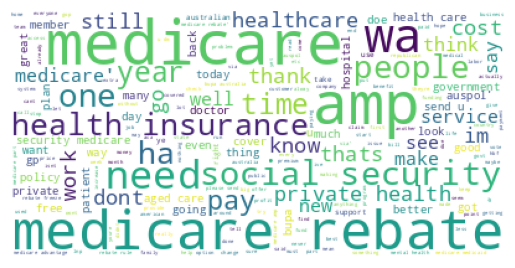

In [46]:
corpus = list(df['tweet_lemmatized'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Text Feature Extraction

### Bigrams

In [47]:
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [48]:
# This function will generate most frequently occuring Bi-grams
def get_ngrams(corpus, ngram_range=(2, 2)):

    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create BoW feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0)

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [49]:
bigrams_medibank = get_ngrams(df['tweet_lemmatized'].tolist(), ngram_range=(2, 2))

In [50]:
bigrams_medibank

[('medicare rebate', 5459),
 ('social security', 2536),
 ('health insurance', 2087),
 ('private health', 1446),
 ('security medicare', 1374),
 ('health care', 1038),
 ('aged care', 1029),
 ('send dm', 894),
 ('medicare medicaid', 854),
 ('bupa australia', 845),
 ('rebate freeze', 614),
 ('please send', 601),
 ('medicare part', 533),
 ('mental health', 524),
 ('rebate rule', 521),
 ('medicare advantage', 498),
 ('get medicare', 475),
 ('medicare australia', 434),
 ('medicare amp', 432),
 ('read bupaaustralia', 407),
 ('health fund', 406),
 ('medicare social', 405),
 ('carejobs agedcare', 404),
 ('amp medicare', 393),
 ('insurance company', 390),
 ('sorry hear', 380),
 ('rick scott', 380),
 ('alzheimers drug', 364),
 ('raise tax', 360),
 ('australia new', 358),
 ('health insurer', 355),
 ('new south', 331),
 ('south wale', 331),
 ('private insurance', 318),
 ('agedcare disabilitysupport', 313),
 ('health system', 312),
 ('last year', 302),
 ('support medicare', 298),
 ('cut medicare', 29

In [51]:
bigrams_medibank_df = pd.DataFrame(bigrams_medibank)
bigrams_medibank_df.columns=["Bi-gram", "Freq"]

/tmp/ipython-input-1807320789.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  h.set_xticklabels(h.get_xticklabels(), rotation=90)


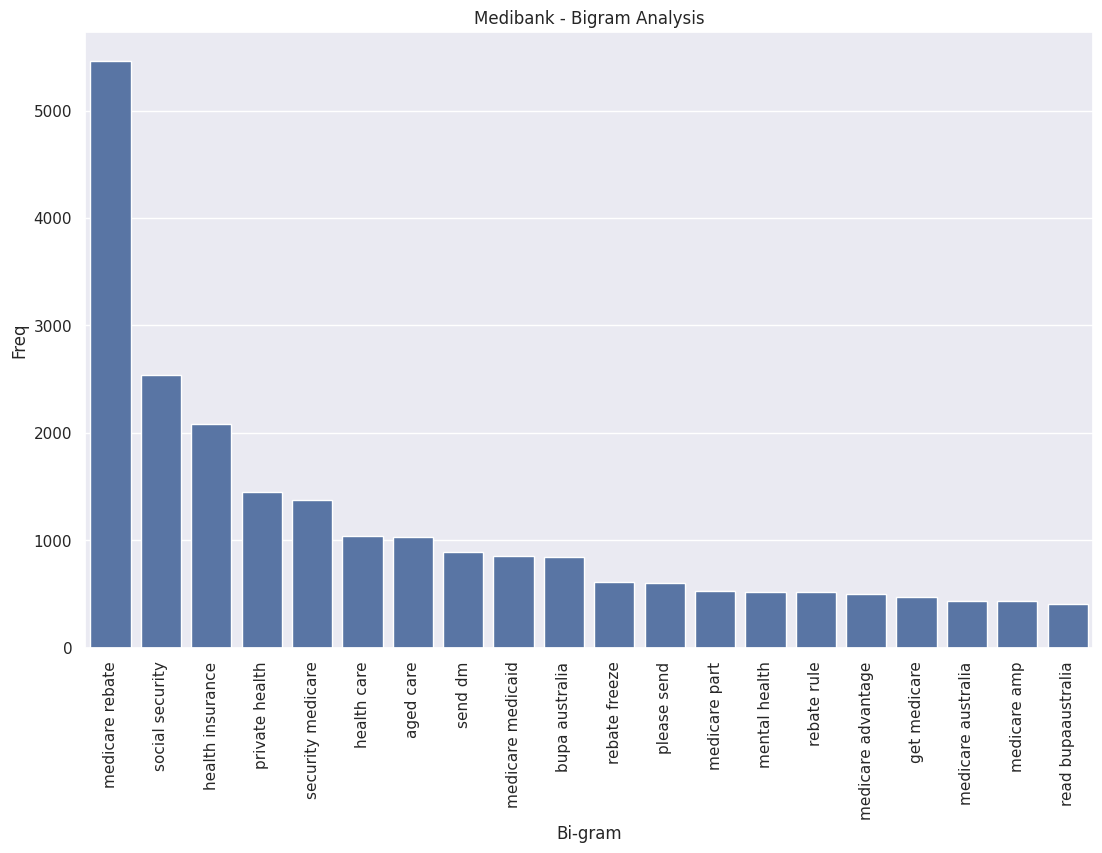

In [52]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigrams_medibank_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Medibank - Bigram Analysis')
plt.show()

In [53]:
trigrams_medibank = get_ngrams(df['tweet_lemmatized'].tolist(), ngram_range=(3, 3))

In [54]:
trigrams_medibank

[('social security medicare', 1354),
 ('private health insurance', 701),
 ('medicare rebate freeze', 555),
 ('please send dm', 465),
 ('medicare social security', 390),
 ('bupa australia new', 331),
 ('new south wale', 331),
 ('australia new south', 322),
 ('carejobs agedcare disabilitysupport', 313),
 ('get medicare rebate', 232),
 ('security medicare medicaid', 197),
 ('send dm detail', 196),
 ('medicare rebate rule', 194),
 ('universal health care', 191),
 ('medicare advantage plan', 191),
 ('social security amp', 159),
 ('end social security', 157),
 ('new alzheimers drug', 153),
 ('security amp medicare', 151),
 ('medicare health insurance', 148),
 ('health insurance tax', 146),
 ('private health insurer', 141),
 ('senior counting rebate', 137),
 ('insurance tax senior', 133),
 ('tax senior counting', 133),
 ('stop medicare health', 132),
 ('medicare amp medicaid', 125),
 ('bupa aged care', 125),
 ('bupa australia victoria', 123),
 ('ceo craig drummond', 120),
 ('away social secur

In [55]:
trigrams_medibank_df = pd.DataFrame(trigrams_medibank)
trigrams_medibank_df.columns=["Tri-gram", "Freq"]

/tmp/ipython-input-240865505.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  h.set_xticklabels(h.get_xticklabels(), rotation=90)


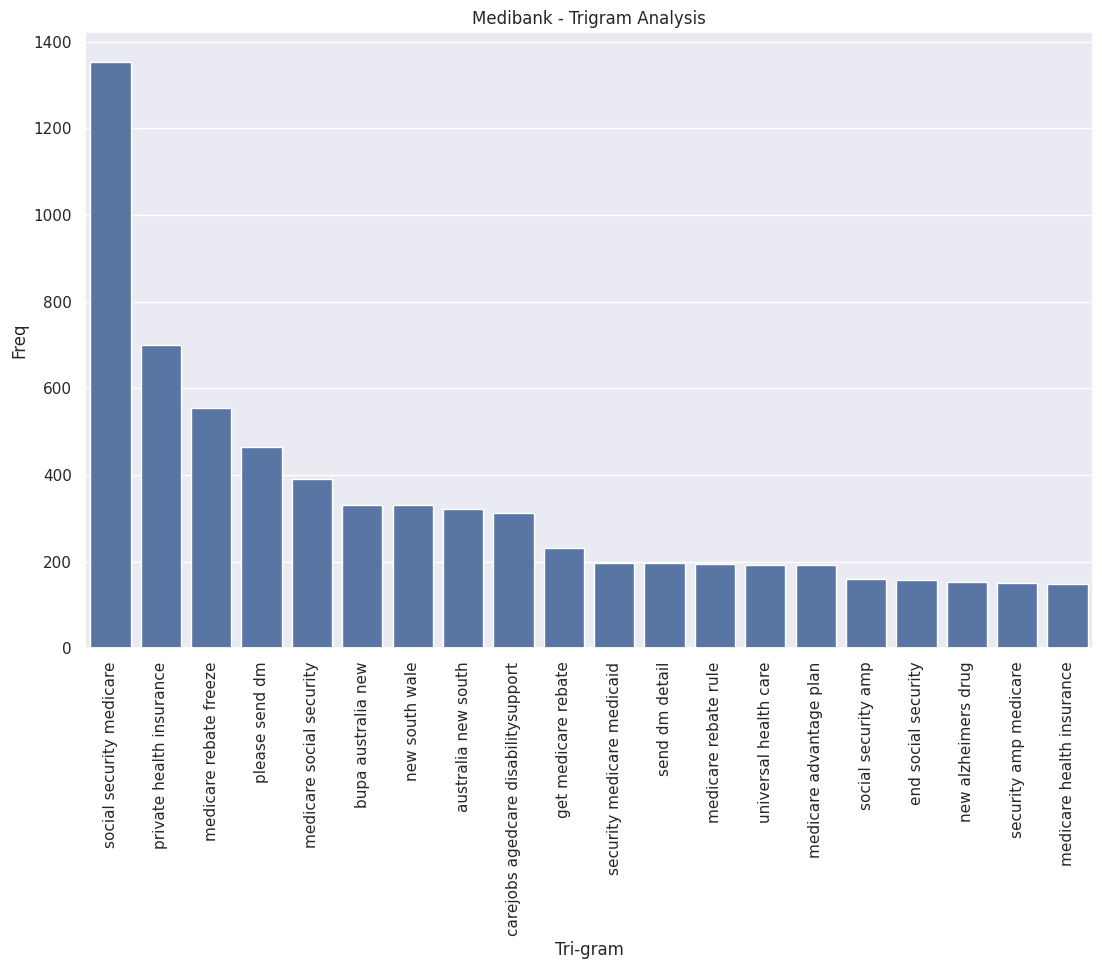

In [56]:
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_medibank_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Medibank - Trigram Analysis')
plt.show()

### Bag of words

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

In [58]:
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1), analyzer = "word")

In [59]:
X_bow = bow.fit_transform(df['tweet_lemmatized'])

In [60]:
df['tweet_lemmatized'].head()

,tweet_lemmatized
id,
3.952669e+16,perth84 amanda help please email socialcomau w...
3.953190e+16,hbf freeway bike hike asthma sun 20th march ra...
3.953896e+16,happen see new ad hbf essential yesterday not ...
3.954256e+16,clement thanks guy great nic
3.954793e+16,damo unfortunately cant online yet em socialco...


In [61]:
print(X_bow)

  (0, 410)	1
  (0, 666)	1
  (0, 273)	1
  (0, 958)	1
  (0, 519)	1
  (0, 878)	1
  (1, 398)	1
  (1, 414)	1
  (1, 716)	1
  (1, 737)	1
  (1, 468)	1
  (1, 352)	1
  (2, 398)	1
  (2, 390)	1
  (2, 784)	1
  (2, 597)	1
  (2, 14)	1
  (2, 992)	1
  (2, 603)	1
  (2, 151)	1
  (2, 363)	1
  (2, 510)	1
  (2, 361)	1
  (2, 524)	1
  (3, 873)	1
  :	:
  (61654, 513)	1
  (61654, 776)	1
  (61654, 649)	1
  (61654, 252)	1
  (61654, 585)	1
  (61655, 362)	1
  (61655, 530)	1
  (61655, 145)	1
  (61655, 75)	1
  (61655, 777)	1
  (61655, 554)	1
  (61655, 72)	1
  (61655, 632)	1
  (61655, 203)	1
  (61656, 480)	1
  (61656, 839)	1
  (61656, 944)	1
  (61656, 369)	1
  (61656, 804)	1
  (61656, 145)	1
  (61656, 89)	1
  (61656, 523)	1
  (61656, 554)	1
  (61656, 500)	1
  (61656, 269)	1


### Term frequency - Inverse Document Frequency (TF-IDF)

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

In [63]:
tf_idf = vectorizer.fit_transform(df['tweet_lemmatized'])

In [64]:
print(vectorizer.get_feature_names_out())

['0000s' '000s' '0057dividend' ... 'zylyz' 'zynlonta' 'zyzzyvamedia']


In [65]:
print(tf_idf[:5])

  (0, 31673)	0.5133125918430513
  (0, 3181)	0.3989456038743373
  (0, 19655)	0.19279969427109797
  (0, 32230)	0.2006600232408251
  (0, 14106)	0.2564200332139229
  (0, 39023)	0.38243427567660665
  (0, 45490)	0.20638962175128484
  (0, 24839)	0.21379259200473155
  (0, 41964)	0.21937316082702585
  (0, 28807)	0.38920519069890586
  (1, 28807)	0.30753429163941587
  (1, 19181)	0.19382651490356428
  (1, 16859)	0.36629165530861224
  (1, 5948)	0.2984144867022805
  (1, 19896)	0.2513626317107599
  (1, 4380)	0.31821409000401013
  (1, 40527)	0.28450866940370734
  (1, 571)	0.3414915011703904
  (1, 25553)	0.25624331958962693
  (1, 34336)	0.24210501895594488
  (1, 35123)	0.23742020346765913
  (1, 22843)	0.210336342040742
  (1, 17087)	0.24029761150057996
  (2, 19181)	0.27840656432544286
  (2, 18942)	0.3314590633318874
  :	:
  (2, 46720)	0.33612504752804845
  (2, 29237)	0.16178588978161568
  (2, 8440)	0.2696621694139058
  (2, 17743)	0.25743095158274676
  (2, 24595)	0.306106652316873
  (2, 17601)	0.17871916

# Temporal Analysis

### Date

In [66]:
df_temp = df[['date','tweet_lemmatized']]

In [67]:
df_temp = df_temp.groupby(['date'])['tweet_lemmatized'].count().reset_index(name='tweet_count').set_index('date')

df_temp

,tweet_count
date,
2011-02-21,9
2011-02-22,4
2011-02-23,2
2011-02-24,5
2011-02-25,4
...,...
2022-04-06,4452
2022-04-07,3272
2022-04-08,2745


Text(0.5, 1.0, 'Tweets Count by Date')

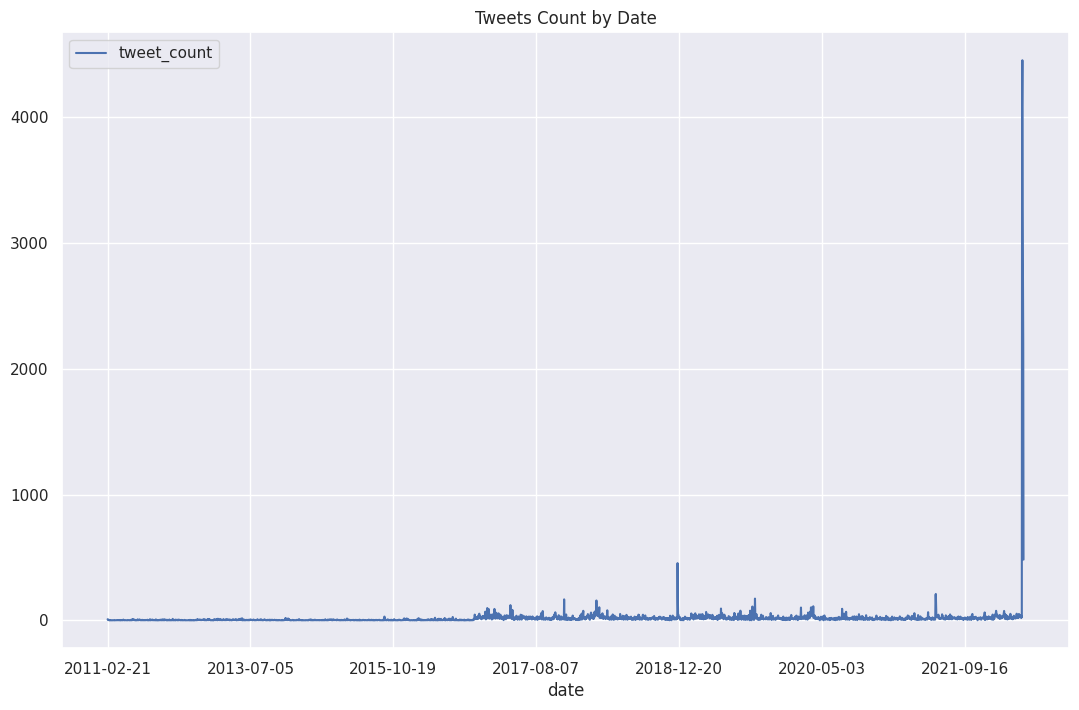

In [68]:
ax = df_temp.plot()
plt.savefig('temporal_analysis.png', dpi=800)
plt.title('Tweets Count by Date')

### Time

In [69]:
df_temp = df[['time','tweet_lemmatized']]

print(df_temp)

                 time                                   tweet_lemmatized
id                                                                      
3.952669e+16  3:27:52  perth84 amanda help please email socialcomau w...
3.953190e+16  3:48:35  hbf freeway bike hike asthma sun 20th march ra...
3.953896e+16  4:16:38  happen see new ad hbf essential yesterday not ...
3.954256e+16  4:30:54                       clement thanks guy great nic
3.954793e+16  4:52:16  damo unfortunately cant online yet em socialco...
...               ...                                                ...
1.512993e+18  3:16:53  birth rate ha replacement rate year dont open ...
1.512993e+18  3:17:02  kellie well wish true minimum wage still unive...
1.512993e+18  3:18:32  mean nothing medicare ha cut point old age pen...
1.512994e+18  3:19:01  whilst australian totally focused getting covi...
1.512994e+18  3:20:06  mediscare show woke labour change narrative su...

[61657 rows x 2 columns]


/tmp/ipython-input-1355638906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['time'] = pd.to_datetime(df_temp['time'], format='%H:%M:%S')


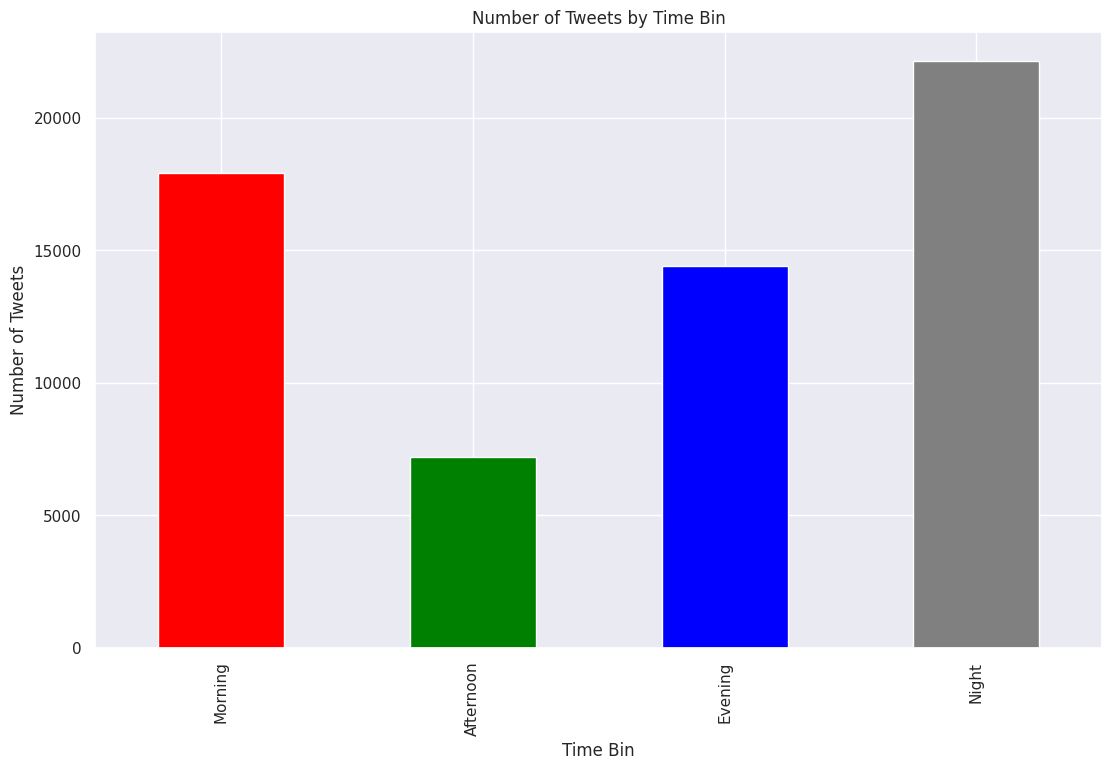

In [70]:
df_temp['time'] = pd.to_datetime(df_temp['time'], format='%H:%M:%S')

df_temp['time_bin'] = df_temp['time'].apply(lambda x: 'Morning' if 6 <= x.hour < 13 else ('Afternoon' if 13 <= x.hour < 18 else ('Evening' if 18 <= x.hour < 24 else 'Night')))

time_bin_counts = df_temp.groupby('time_bin')['tweet_lemmatized'].count()

time_bin_counts = time_bin_counts.reindex(['Morning', 'Afternoon', 'Evening', 'Night'])

time_bin_counts.plot(kind='bar', color=['red', 'green', 'blue', 'grey'])
plt.xlabel('Time Bin')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets by Time Bin')
plt.show()

# Sentiment over Time

### Sentiment on overall data

In [71]:
df['sentiment'] = df['tweet_lemmatized'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [72]:
df[['tweet_lemmatized', 'sentiment']].head(50)

,tweet_lemmatized,sentiment
id,,
3.952669e+16,perth84 amanda help please email socialcomau w...,0.000000
3.953190e+16,hbf freeway bike hike asthma sun 20th march ra...,0.150000
3.953896e+16,happen see new ad hbf essential yesterday not ...,-0.017045
3.954256e+16,clement thanks guy great nic,0.500000
3.954793e+16,damo unfortunately cant online yet em socialco...,-0.250000
3.954810e+16,clement cheer rob,0.000000
3.959100e+16,need tip eating well improve health checkout d...,0.000000
3.962824e+16,hope everyone safe perth cbd,0.500000
3.981990e+16,keep date travel advice oz govt smartraveller ...,0.000000


In [73]:
category = []
for sentiment in df['sentiment']:
    if sentiment < 0:
        category.append("Negative")
    elif sentiment == 0:
        category.append("Neutral")
    else:
        category.append("Positive")
df['category'] = category

In [74]:
df[['tweet_lemmatized', 'sentiment', 'category']].head(50)

,tweet_lemmatized,sentiment,category
id,,,
3.952669e+16,perth84 amanda help please email socialcomau w...,0.000000,Neutral
3.953190e+16,hbf freeway bike hike asthma sun 20th march ra...,0.150000,Positive
3.953896e+16,happen see new ad hbf essential yesterday not ...,-0.017045,Negative
3.954256e+16,clement thanks guy great nic,0.500000,Positive
3.954793e+16,damo unfortunately cant online yet em socialco...,-0.250000,Negative
3.954810e+16,clement cheer rob,0.000000,Neutral
3.959100e+16,need tip eating well improve health checkout d...,0.000000,Neutral
3.962824e+16,hope everyone safe perth cbd,0.500000,Positive
3.981990e+16,keep date travel advice oz govt smartraveller ...,0.000000,Neutral


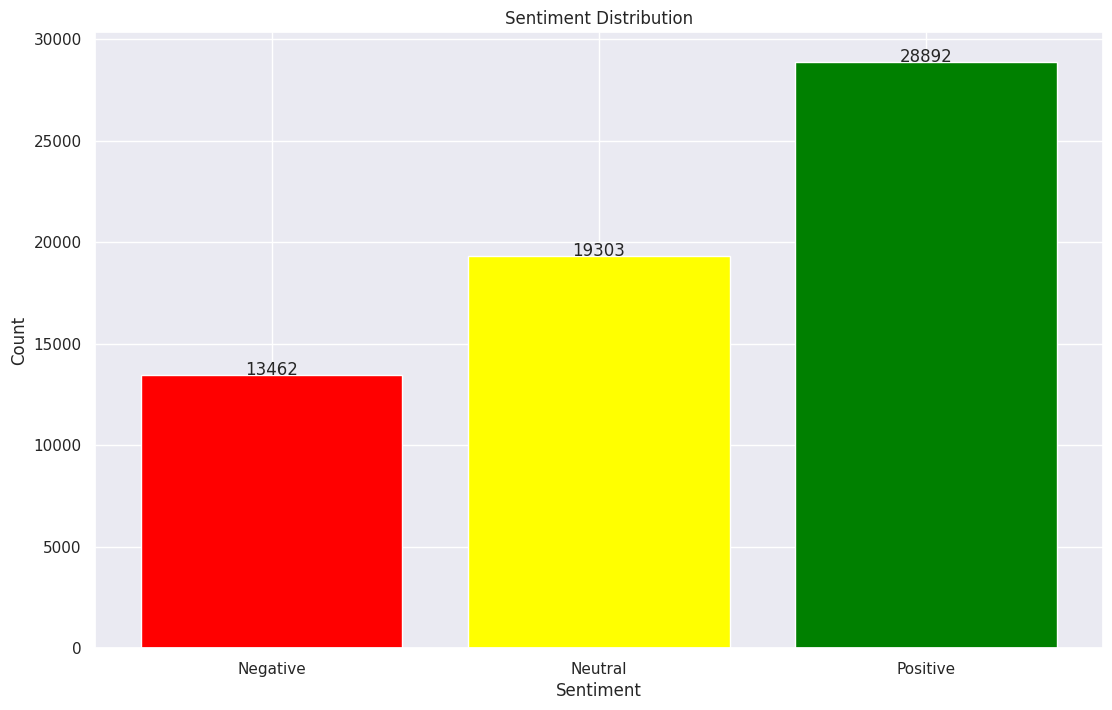

In [75]:
category_counts = df.groupby(['category']).count()['tweet_lemmatized']

# Define colors for each sentiment category
colors = {'Negative': 'red', 'Neutral': 'yellow', 'Positive': 'green'}

# Create a bar plot
fig, ax = plt.subplots()
for category, count in category_counts.items():
    ax.bar(category, count, color=colors[category], label=sentiment)
    ax.text(category, count+5, str(count), ha='center')

ax.set_title('Sentiment Distribution')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.show()

In [76]:
df_senti = df.groupby(['date'])['sentiment'].mean().reset_index(name='mean_sentiment').set_index('date')

In [77]:
df_senti

,mean_sentiment
date,
2011-02-21,0.098106
2011-02-22,0.204167
2011-02-23,-0.375000
2011-02-24,0.300000
2011-02-25,0.008767
...,...
2022-04-06,0.053086
2022-04-07,0.060297
2022-04-08,0.060450


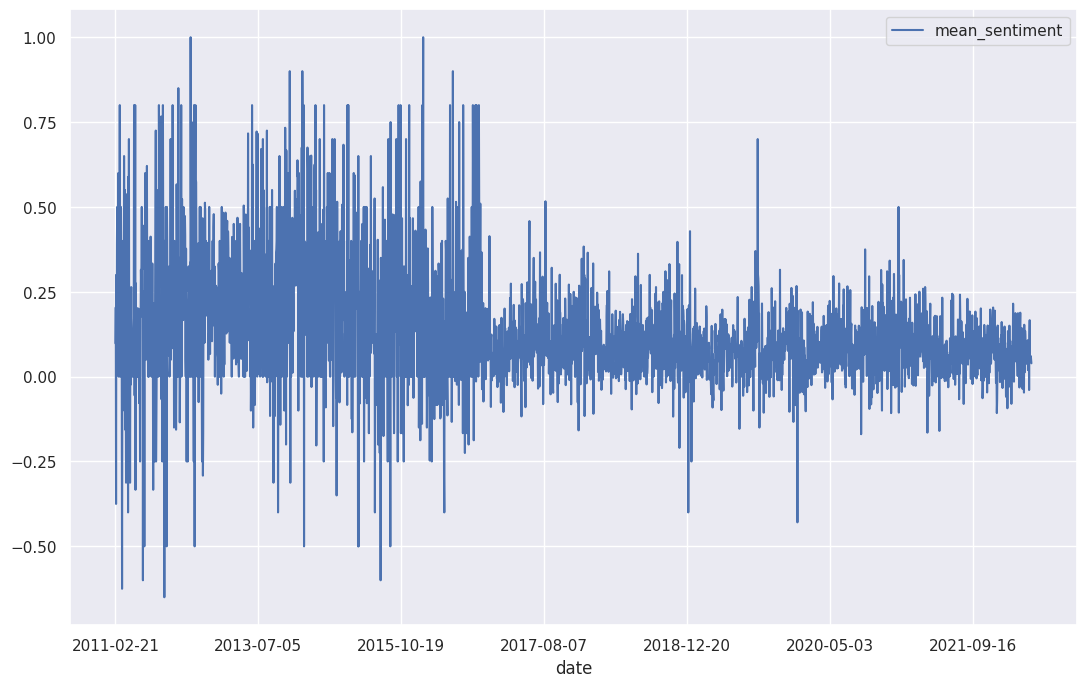

In [78]:
ax = df_senti.plot()
plt.savefig('temporal_sentiment_v2.png', dpi=800)

### Sentiment on Year

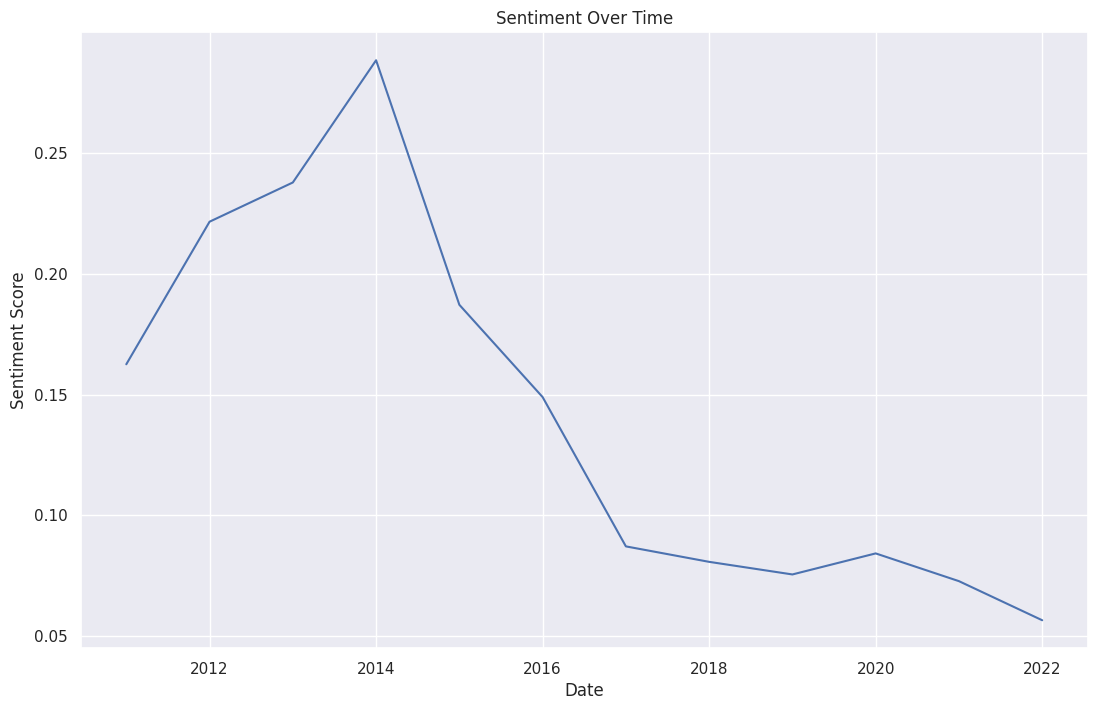

In [79]:
# convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# extract the year from the 'date' column and create a new 'year' column
df['year'] = df['date'].dt.year

# group the tweets by date and calculate the average sentiment score for each day
yr_sentiment = df.groupby('year')['sentiment'].mean().reset_index()

# plot the sentiment scores over time using a line chart
plt.plot(yr_sentiment['year'], yr_sentiment['sentiment'])
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Over Time')
plt.show()

### Sentiment on Month

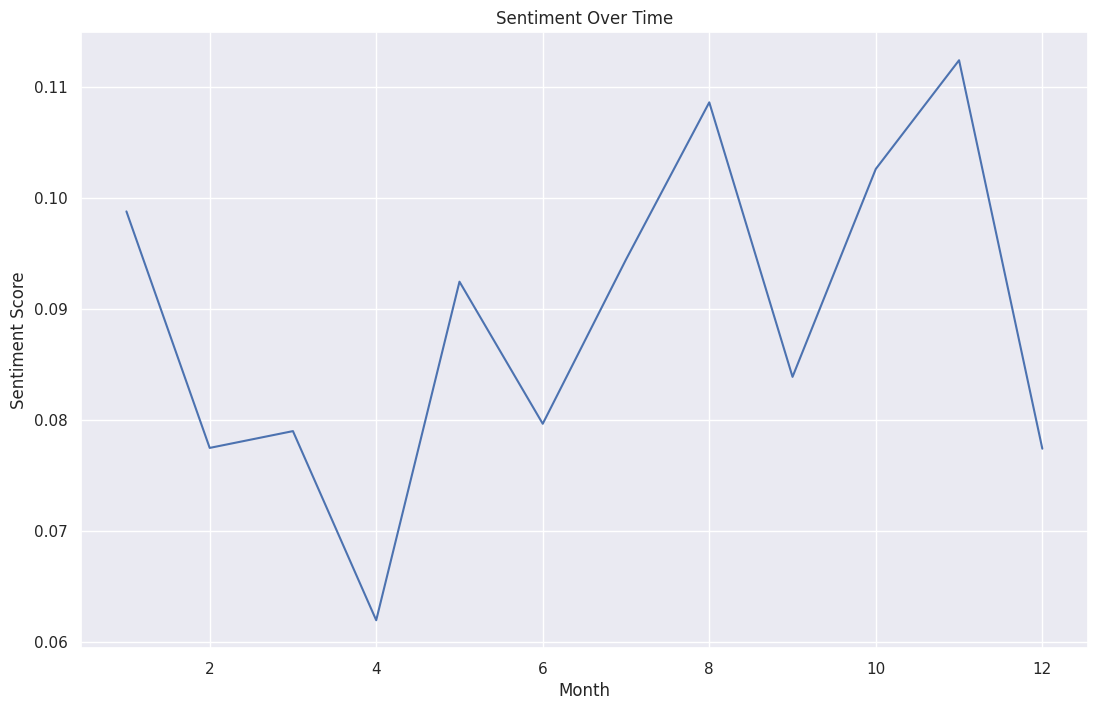

In [80]:
# convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# extract the year from the 'date' column and create a new 'year' column
df['month'] = df['date'].dt.month

# group the tweets by date and calculate the average sentiment score for each day
mth_sentiment = df.groupby('month')['sentiment'].mean().reset_index()

# plot the sentiment scores over time using a line chart
plt.plot(mth_sentiment['month'], mth_sentiment['sentiment'])
plt.xlabel('Month')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Over Time')
plt.show()

# Topic Modelling

In [81]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [82]:
corpus = list(df['tweet_lemmatized'])

In [83]:
corpus[:5]

['perth84 amanda help please email socialcomau well look thing nic',
 'hbf freeway bike hike asthma sun 20th march raising register join fun nic',
 'happen see new ad hbf essential yesterday not check give little get lot',
 'clement thanks guy great nic',
 'damo unfortunately cant online yet em socialcomau well call u back email quote nic']

In [84]:
text = [[word for word in str(document).split()] for document in corpus]

In [85]:
text[:5]

[['perth84',
  'amanda',
  'help',
  'please',
  'email',
  'socialcomau',
  'well',
  'look',
  'thing',
  'nic'],
 ['hbf',
  'freeway',
  'bike',
  'hike',
  'asthma',
  'sun',
  '20th',
  'march',
  'raising',
  'register',
  'join',
  'fun',
  'nic'],
 ['happen',
  'see',
  'new',
  'ad',
  'hbf',
  'essential',
  'yesterday',
  'not',
  'check',
  'give',
  'little',
  'get',
  'lot'],
 ['clement', 'thanks', 'guy', 'great', 'nic'],
 ['damo',
  'unfortunately',
  'cant',
  'online',
  'yet',
  'em',
  'socialcomau',
  'well',
  'call',
  'u',
  'back',
  'email',
  'quote',
  'nic']]

In [86]:
# Create a dictionary based on the tokanized words of all the tweets.
dictionary = corpora.Dictionary(text)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'dict'))

In [87]:
print(text[0])
print('alphabetically sorted', sorted(text[0]))

['perth84', 'amanda', 'help', 'please', 'email', 'socialcomau', 'well', 'look', 'thing', 'nic']
alphabetically sorted ['amanda', 'email', 'help', 'look', 'nic', 'perth84', 'please', 'socialcomau', 'thing', 'well']


In [89]:
print(text[1])
print('alphabetically sorted', sorted(text[1]))

['hbf', 'freeway', 'bike', 'hike', 'asthma', 'sun', '20th', 'march', 'raising', 'register', 'join', 'fun', 'nic']
alphabetically sorted ['20th', 'asthma', 'bike', 'freeway', 'fun', 'hbf', 'hike', 'join', 'march', 'nic', 'raising', 'register', 'sun']


In [90]:
print(dictionary.token2id)

{'amanda': 0, 'email': 1, 'help': 2, 'look': 3, 'nic': 4, 'perth84': 5, 'please': 6, 'socialcomau': 7, 'thing': 8, 'well': 9, '20th': 10, 'asthma': 11, 'bike': 12, 'freeway': 13, 'fun': 14, 'hbf': 15, 'hike': 16, 'join': 17, 'march': 18, 'raising': 19, 'register': 20, 'sun': 21, 'ad': 22, 'check': 23, 'essential': 24, 'get': 25, 'give': 26, 'happen': 27, 'little': 28, 'lot': 29, 'new': 30, 'not': 31, 'see': 32, 'yesterday': 33, 'clement': 34, 'great': 35, 'guy': 36, 'thanks': 37, 'back': 38, 'call': 39, 'cant': 40, 'damo': 41, 'em': 42, 'online': 43, 'quote': 44, 'u': 45, 'unfortunately': 46, 'yet': 47, 'cheer': 48, 'rob': 49, 'blog': 50, 'checkout': 51, 'dietitian': 52, 'eating': 53, 'hay': 54, 'health': 55, 'improve': 56, 'margaret': 57, 'need': 58, 'tip': 59, 'weekly': 60, 'cbd': 61, 'everyone': 62, 'hope': 63, 'perth': 64, 'safe': 65, 'advice': 66, 'date': 67, 'east': 68, 'esp': 69, 'govt': 70, 'heading': 71, 'keep': 72, 'middle': 73, 'oz': 74, 'smartraveller': 75, 'travel': 76, 'y

In [91]:
corpus = [dictionary.doc2bow(t) for t in text]

In [92]:
tweet_id = 0
print(text[tweet_id]) # each tweet converted to tokens
print(dictionary.doc2bow(text[tweet_id])) # each token is represented as a id from a dictionary

['perth84', 'amanda', 'help', 'please', 'email', 'socialcomau', 'well', 'look', 'thing', 'nic']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


### Generate the Topic Model

In [93]:
tfidf = models.TfidfModel(corpus)

In [94]:
corpus_tfidf = tfidf[corpus]

In [95]:
total_topics = 10

In [96]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [97]:
# Print the Keyword in the 10 topics
lda.show_topics(total_topics, num_words=6)

[(0,
  '0.035*"program" + 0.023*"said" + 0.016*"policy" + 0.016*"done" + 0.013*"like" + 0.013*"people"'),
 (1,
  '0.040*"senior" + 0.029*"class" + 0.025*"limit" + 0.021*"new" + 0.020*"card" + 0.016*"eliminate"'),
 (2,
  '0.049*"coverage" + 0.036*"u" + 0.029*"alzheimers" + 0.026*"scott" + 0.019*"please" + 0.018*"rick"'),
 (3,
  '0.172*"medicare" + 0.024*"social" + 0.024*"security" + 0.019*"tax" + 0.015*"amp" + 0.014*"plan"'),
 (4,
  '0.039*"government" + 0.021*"australia" + 0.018*"people" + 0.017*"health" + 0.015*"rich" + 0.013*"bupa"'),
 (5,
  '0.046*"cost" + 0.021*"labor" + 0.018*"amp" + 0.014*"country" + 0.014*"didnt" + 0.013*"people"'),
 (6,
  '0.027*"not" + 0.021*"im" + 0.018*"people" + 0.012*"dont" + 0.012*"healthcare" + 0.011*"know"'),
 (7,
  '0.033*"advantage" + 0.030*"healthcare" + 0.013*"climate" + 0.011*"health" + 0.010*"million" + 0.010*"housing"'),
 (8,
  '0.069*"care" + 0.021*"patient" + 0.017*"aged" + 0.011*"rate" + 0.011*"law" + 0.010*"healthcare"'),
 (9,
  '0.038*"drug"

For example, a topic is represented as 0.024*"health" + 0.017*"private" + 0.013*"not" + 0.010*"cover" + 0.009*"amp" + 0.008*"time"

Based on the keywords in the topic and their weights, we can summarize it as the problem of a private health that is not covered.

Or, another example is 0.037*"free" + 0.024*"feelgoodprogram" + 0.019*"parkrun" + 0.013*"fitness" + 0.011*"get" + 0.010*"legend".

This may be assumed as the free parkrun program receiving good feedback from participants.

### Interactive Topic Analyzer

In [98]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      17.816193 -12.584268       1        1  41.317287
6      -2.447694   9.877927       2        1  11.804785
0      33.733360 -15.697170       3        1   6.988919
3      16.160185  18.530336       4        1   5.701478
9     -13.421789  -6.389685       5        1   5.701211
4      16.585758 -28.924669       6        1   5.699078
5      30.820765   3.187288       7        1   5.696890
1      13.785413   2.687501       8        1   5.696831
7       2.570810  -8.453329       9        1   5.696829
8      -1.603199 -24.472548      10        1   5.696693, topic_info=            Term         Freq        Total Category  logprob  loglift
4618    medicare   615.000000   615.000000  Default  30.0000  30.0000
3209    coverage  1254.000000  1254.000000  Default  29.0000  29.0000
1058        care   320.000000   320.000000  Default  28.0000  28.0000
5709  alzheimers   740.000000   740.000000  Default  27.0000  27.0000
2983       scott   663.000000   663.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1556  healthcare    36.336287   278.310677  Topic10  -4.5712   0.8294
666          amp    32.484409   284.855764  Topic10  -4.6833   0.6941
932         even    27.838049   242.632758  Topic10  -4.8377   0.7001
162          day    21.940489    71.116921  Topic10  -5.0757   1.6893
108         home    20.366039    58.521636  Topic10  -5.1502   1.8098

[549 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1446      3  0.788590  absolutely
1446      6  0.197148  absolutely
6127      5  1.004611         aca
2110      5  0.531832      access
2110      6  0.468012      access
...     ...       ...         ...
77        5  0.032452       youre
77        7  0.024339       youre
77        8  0.008113       youre
77        9  0.008113       youre
77       10  0.048678       youre

[986 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 1, 4, 10, 5, 6, 2, 8, 9])